Основные цели этого задания:

- Закрепить теорию построения сплитов в дереве решений.
- Изучить и реализовать алгоритм построения дерева.
- Разобраться, как работают параметры .

Задача:

Построить модель машинного обучения, предсказывающую траты у посетителей магазина.

In [13]:
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor, export_text
import re
from matplotlib import pyplot as plt
from summarytools import dfSummary
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

1. Загрузите данные и подготовьте их: 
- Сделайте из текстового признака, обозначающего пол, бинарный флаг 0/1
- Переименуйте признаки так, чтобы в названиях не было пробелов.

In [14]:
# загружаем данные
df = pd.read_csv('Mall_Customers.csv')
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CustomerID[int64],Mean (sd) : 100.5 (57.9)min < med < max:1.0 < 100.5 < 200.0IQR (CV) : 99.5 (1.7),200 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Genre[object],1. Female2. Male,112 (56.0%)88 (44.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bQWqDQByF8TdFQrOZQQQP4yF62B5ibiPiLJqQjV1kE+K280bs9zvBH/kQEnxh2zYBDkHSVdKl9SEn9di27db6iKPohmH4ijH2rQ85o1LKEkL4JrinLsbYT9N0SyndWx9zJuu6fuac+3meL5KITVInSSml+ziOP62POaFr6wOO5KP1Afg/iA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssOmk54d+rQ85G57pXldKWXLOvfjQ78+VUhZJj9Z3HAWDl7oYvLwITPngwpttj7dRJUz53jC/q4cp3wvmd3Ux5dvjV3kl/KkLG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yY8r3gOdTFlO8N87t6GLzsMXip5BcKW2rfwvGDvwAAAABJRU5ErkJggg=="">",0(0.0%)
3,Age[int64],Mean (sd) : 38.9 (14.0)min < med < max:18.0 < 36.0 < 70.0IQR (CV) : 20.2 (2.8),51 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACj0lEQVR4nO3cTYriQBiA4a8mrUSFBBF05wUGZuHSQ8xh5wiz8ATewJ0gIWKmgzFmVt0wYPuTSk3qK95nX3YWL239xDJN0wjgu299PwDwjLe+H+AeY8xIRIYth5+bpnnv8nnQH29DNcaMZrPZzyRJpm3GH4/HzBjzi1jD4G2oIjJMkmS6Xq/f0zQtXxmY53m82Wymh8NhKCKEGgCfQxURkTRNy/l8/qfF0FHnD4PesJiCCoQKFR5+9bPyhg/uhsrKG7549B+VlTe88NSqn5U3+ub99lRbdV0PRCQxxrT9CObXHgky1KIoBlVV/Vgul1EURS9NWT4wv/ZLkKGez+e3OI7Hq9WqXCwW2avjmV/7J8hQP0wmk7ZzaxHm115hwx8qECpUCPqrvy+c5nWPUDvGaZ4bhNo9TvMcIFRHOM3rFospqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFDB6RGq5e+Wkuv1Ouj4kaCUs1Btf7dUVVVc1/X3six/i0jbt/QRCGeh2v5uabfbTbfb7fhyuUQung+6OH97qu3vlrIs4y0ifGIxBRUIFSrw4vQXLHYs2K1wgFBvsNmxYLfCDUK9wWbHwna3gjuzbiPUO9rsWNjsVnBn1tcI1SPa78xyeZ8BoXpI451Zru8zIFR0xel9BoSKTrm6z4ANf6hAqFCBUKECc9TAWB4YeHtYQKgBsT0w8PmwgFADYnNg0PdhwSOEGiCLAwNvX1ZnMQUVCBUqECpUIFSowGIKn3y+MIRQISL+XxhCqBAR/y8MIVT8w9cLQ1hMQQVChQqEChUIFSoQKlQgVKhAqFCBUKHCUxv+eZ7Hr37w6XSKRUSKooj3+/34f47X+re1Prft+Gf6+guRZMaxJPMCIgAAAABJRU5ErkJggg=="">",0(0.0%)
4,Annual Income (k$)[int64],Mean (sd) : 60.6 (26.3)min < med < max:15.0 < 61.5 < 137.0IQR (CV) : 36.5 (2.3),64 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACxUlEQVR4nO3dP2/aQBjH8d9BiMwfGSFUsrF0rNSBkRfRF9uX0IFXwNClU7ZIEQLFDcIYd2pVKpJgHy73XL6f/YiHr6pH5/PVlWUpIHStaz8AcI6baz9AU5xzXUm3Hj+xK8vy+VLPAz9Rhuqc647H4y9pmo7q/sZms1k5574SaxiiDFXSbZqmo/l8/jwcDrdVF6/X62SxWIweHx9vJRFqAGINVZI0HA63k8nkZ83l3Ys+DLxEHeq1eM7HzMYnEOqF+c7HzManEerl1Z6PmY1fRqgN8ZiPmY1PYMMfJhAqTCBUmECoMIFQYQKhwgS2p15QFEVHUuqcq7o0PRwOnQYe6V0j1BOyLOvkef55Op222+12pU37PM+Toig+bbfbb5LqnjPAPwj1hN1ud5MkSW82m23v7u5WVdbe39+Plstlb7/ft5t6vveIUF/R7/crv11arVa8WWpA0KF6nEJiToxMsKH6nEJiToxPsKHK4xQSc2J8Qg5VUr1TSMyJ8WHDHyYQKkwgVJjw5ozKh2oIwauh8qEaQvHWv6h8qIYgnLU9VfdDtaIoUtU7gSTxdgl/aWwf1ecEksTbJRxrLFSfE0gSb5dwrPE3U3VOIEm8XcIx9lFhAqHCBEKFCYQKEwgVJhAqTCBUmECoMIFQYQKhwgRChQmEChMIFSYQKkwgV

In [15]:
df.columns = [re.sub('(?<!^)(?=[A-Z])|[ ]', '_', i, count=1).lower() for i in df]
df.columns

Index(['customer_id', 'genre', 'age', 'annual_income (k$)',
       'spending_score (1-100)'],
      dtype='object')

In [16]:
# Переименовываем колонку "annual_income (k$)" на "annual_salary"
df = df.rename(columns={"annual_income (k$)": "annual_salary"})

# Переименовываем колонку "spending_score (1-100)" на "spending_total_score"
df = df.rename(columns={"spending_score (1-100)": "spending_total_score"})

# Переименовываем колонку "genre" на "gender"
df = df.rename(columns={"genre": "gender"})

In [17]:
# отделяем признаки
features = df[['gender', 'age', 'annual_salary']].copy()
features['gender'] = (features['gender'] == 'Male') * 1
features.head()

,gender,age,annual_salary
0,1,19,15
1,1,21,15
2,0,20,16
3,0,23,16
4,0,31,17


In [18]:
# отделяем целевую переменную
target = df['spending_total_score']
target.head()

0    39
1    81
2     6
3    77
4    40
Name: spending_total_score, dtype: int64

Рассчитаем исходный джини

In [19]:
def calc_gini(values, classes = [0, 1]):
    if len(values) == 0:
        return 0
    
    res = 1
    for c in classes:
        res -= (len([v for v in values if v == c]) / len(values)) ** 2
    return res

In [20]:
init_gini = calc_gini(target)
init_gini

0.9999

Рассчитаем исходный разброс

In [21]:
def calc_squared_error(values):
    mean_value = values.mean()
    res = sum([(v - mean_value) ** 2 for v in values]) / len(values)
    return res

In [22]:
init_mse = calc_squared_error(target)
init_mse

663.5199999999994

2. Доработайте функцию построения сплита (разработанную в рамках скринкаста):

- Занесите расчет хаотичности целевого признака в выборке в саму функцию построения сплита

- Уберите промежуточные выводы

- В качестве результата отработки функции возвращайте пару “признак”+”значение для сплита”, при которых достигается наилучший прирост информации. Если таких не нашлось (если выборка однородна с точки зрения всех признаков и ее невозможно разделить), возвращайте, например, None.

- Сделаем функцию похожей на библиотечную: пусть она принимает на вход отдельно датафрейм с признаками (назовите параметр X ) и столбец со значениями целевого признака (назовите y). Доработайте код функции под новые входные данные. Подсказка: чтобы понять, какие значения целевого признака будут принимать объекты, попавшие в левую/правую часть подвыборки, создайте маску из столбца с фичей и примените ее к столбца с целевым признаком:

- Чтобы получить маску, к столбцу в признаком, по которому происходит деление примените операцию сравнения со значением, по которому хотите выполнить сплит. Получится столбец из True/False длины, равной количеству элементов в исходной выборке, подлежащей сплиту.

- Примените полученную маску к столбцу с целевыми значениями target[mask]. В итоге останутся только значения целевой переменной для наблюдений, которым в маске соответствовало значение True.

In [23]:
X = features
y = target

def find_best_split(X, y):
    best_information_gain = 0
    best_feature_split = None
    
    # Вычисляем начальную хаотичность выборки
    init_criterion_value = calc_gini(y)
    
    # Перебираем все признаки
    for feature_name in X.columns:
        # Составляем значения для сплитов по признаку
        diff_feature_values = X[feature_name].unique()
        
        # Перебираем возможные сплиты по признаку
        for i in range(len(diff_feature_values) - 1):
            information_gain = init_criterion_value
            
            # Вычисляем значение сплита
            split_value = (diff_feature_values[i] + diff_feature_values[i+1]) / 2
            
            # Вычисляем хаотичность в левой группе
            mask = X[feature_name] <= split_value
            criterion_value_for_group = calc_gini(y[mask])
            ratio_for_group = len(y[mask]) / len(y)
            information_gain -= criterion_value_for_group * ratio_for_group
            
            # Вычисляем хаотичность в правой группе
            mask = X[feature_name] > split_value
            criterion_value_for_group = calc_gini(y[mask])
            ratio_for_group = len(y[mask]) / len(y)
            information_gain -= criterion_value_for_group * ratio_for_group
            
            # Обновляем лучшую точку сплита
            if best_information_gain < information_gain:
                best_information_gain = information_gain
                best_feature_split = (feature_name, split_value)
    
    # Если не нашли хорошего сплита, возвращаем None
    if best_information_gain == 0:
        return None
    else:
        return best_feature_split

3. Реализуйте функцию построения решающего дерева fit_regression_tree, допускающую ограничения на максимальную глубину дерева, а также минимальное число наблюдений в выборке, подлежащей сплиту. В результате запуска функции должны быть выведены правила, по которым должен происходить сплит, а в листьях - предикт (то есть среднее значение целевого признака на подвыборке обучающего датафйрема, попавшей в этот лист). Бинарное дерево строится рекурсивной, поэтому функция его простроения тоже будет рекурсивной:

- Реализуйте часть для выхода из рекурсии. Здесь должна выполняться проверка на достижение максимально допустимой глубины дерева/достаточное количество наблюдений в выборке для выполнения очередного сплита/возможность построения сплита. Невозможно построить сплит, если все объекты в выборке одинаковы с точки зрения значений фичей. Если одно из этих условий выполняется, выводите предикт в следующем формате:
"|   " * <текущая глубина дерева>"|---" value: <предикт с 2 знаками после запятой>]'

- Реализуйте альтернативный путь для дальнейшего построения дерева:

- Выведите правило, по которому наблюдения “идут влево” в формате:
"|   " * <текущая глубина дерева>"|---" <фича для сплита> <= <значение для сплита>

- Постройте сплит “пошедшей влево” подвыборки

- Выведите правило, по которому наблюдения “идут вправо” в формате:
"|   " * <текущая глубина дерева>"|---" <фича для сплита> > <значение для сплита>

- Постройте сплит “пошедшей вправо” подвыборки.

In [24]:
def fit_regression_tree(X, y, max_depth=None, min_samples_split=2):
    
    def build_tree(X, y, current_depth=0, max_depth=None, min_samples_split=2):
        # Проверяем условии выхода из рекурсии
        if (max_depth is not None and current_depth >= max_depth) or len(y) < min_samples_split or len(set(y)) == 1:
            # Возвращаем предикт в виде среднего значения y
            prediction = round(y.mean(), 2)
            print("|   " * current_depth + "|---", f"value: {prediction}")
            return prediction
        
        # Находим лучший сплит
        best_split = find_best_split(X, y)
        if best_split is None:
            # Если сплит не найден, возвращаем предикт
            prediction = round(y.mean(), 2)
            print("|   " * current_depth + "|---", f"value: {prediction}")
            return prediction
        
        # Распаковываем лучший сплит
        feature_name, split_value = best_split
        
        # Выводим правило для левой ветви
        print("|   " * current_depth + "|---", f"{feature_name} <= {split_value}")
        
        # Строим левую ветвь
        mask = X[feature_name] <= split_value
        left_prediction = build_tree(X[mask], y[mask], current_depth + 1, max_depth, min_samples_split)
        
        # Выводим правило для правой ветви
        print("|   " * current_depth + "|---", f"{feature_name} > {split_value}")
        
        # Строим правую ветвь
        mask = X[feature_name] > split_value
        right_prediction = build_tree(X[mask], y[mask], current_depth + 1, max_depth, min_samples_split)
        
        return {
            "feature": feature_name,
            "split_value": split_value,
            "left": left_prediction,
            "right": right_prediction
        }
    
    # Запускаем рекурсивную функцию построения дерева
    return build_tree(X, y, max_depth=max_depth, min_samples_split=min_samples_split)

4. Проверьте корректность реализованного алгоритма

- Убедитесь, что без ошибок строится дерево без ограничений (то есть до последнего возможного сплита)

- Убедитесь, что без ошибок отрабатывает алгоритм для построения дерева с ограничением на глубину. Выберите максимально допустимую глубину, равную 2. Также постройте дерево с помощью библиотечного алгоритма (DecisionTreeRegressor) на тех же входных данных. Выведите его с помощью функции export_text и сравните построенные деревья. Они должны совпадать. 

- Убедитесь, что без ошибок отрабатывает алгоритм для построения дерева с ограничением на минимальное количество элементов в выборке, над которой производится в сплит. Также сравните построенное дерево с деревом, построенным с помощью библиотечной реализации, при ограничении min_samples_split=70.

In [25]:
# Проверим, что дерево построено без ошибок, построим дерево с ограничением на глубину, равную 2:
fit_regression_tree_depth = fit_regression_tree(X, y, max_depth=2)

|--- annual_salary <= 77.5
|   |--- annual_salary <= 39.5
|   |   |--- value: 49.74
|   |--- annual_salary > 39.5
|   |   |--- value: 50.41
|--- annual_salary > 77.5
|   |--- annual_salary <= 78.5
|   |   |--- value: 47.58
|   |--- annual_salary > 78.5
|   |   |--- value: 50.98


In [26]:
sklearn_tree = DecisionTreeRegressor(max_depth=2)
sklearn_tree.fit(X, y)

print(export_text(sklearn_tree, feature_names=list(features.columns)))

|--- age <= 39.50
|   |--- age <= 20.50
|   |   |--- value: [44.65]
|   |--- age >  20.50
|   |   |--- value: [62.53]
|--- age >  39.50
|   |--- annual_salary <= 72.00
|   |   |--- value: [41.77]
|   |--- annual_salary >  72.00
|   |   |--- value: [19.79]



In [27]:
fit_regression_tree_split = fit_regression_tree(X, y, min_samples_split=70)

|--- annual_salary <= 77.5
|   |--- annual_salary <= 39.5
|   |   |--- value: 49.74
|   |--- annual_salary > 39.5
|   |   |--- age <= 38.5
|   |   |   |--- value: 53.06
|   |   |--- age > 38.5
|   |   |   |--- value: 48.15
|--- annual_salary > 77.5
|   |--- value: 50.19


In [28]:
sklearn_tree = DecisionTreeRegressor(min_samples_split=70)
sklearn_tree.fit(X, y)

print(export_text(sklearn_tree, feature_names=list(features.columns)))

|--- age <= 39.50
|   |--- age <= 20.50
|   |   |--- value: [44.65]
|   |--- age >  20.50
|   |   |--- age <= 32.50
|   |   |   |--- value: [66.59]
|   |   |--- age >  32.50
|   |   |   |--- value: [55.09]
|--- age >  39.50
|   |--- annual_salary <= 72.00
|   |   |--- value: [41.77]
|   |--- annual_salary >  72.00
|   |   |--- value: [19.79]



In [29]:
fit_regression_tree_full = fit_regression_tree(X, y)

|--- annual_salary <= 77.5
|   |--- annual_salary <= 39.5
|   |   |--- age <= 30.5
|   |   |   |--- annual_salary <= 31.5
|   |   |   |   |--- annual_salary <= 15.5
|   |   |   |   |   |--- value: 60.0
|   |   |   |   |--- annual_salary > 15.5
|   |   |   |   |   |--- annual_salary <= 18.5
|   |   |   |   |   |   |--- value: 63.25
|   |   |   |   |   |--- annual_salary > 18.5
|   |   |   |   |   |   |--- value: 76.12
|   |   |   |--- annual_salary > 31.5
|   |   |   |   |--- annual_salary <= 33.5
|   |   |   |   |   |--- value: 86.5
|   |   |   |   |--- annual_salary > 33.5
|   |   |   |   |   |--- value: 76.25
|   |   |--- age > 30.5
|   |   |   |--- annual_salary <= 20.5
|   |   |   |   |--- age <= 33.0
|   |   |   |   |   |--- value: 40.0
|   |   |   |   |--- age > 33.0
|   |   |   |   |   |--- age <= 62.5
|   |   |   |   |   |   |--- value: 33.25
|   |   |   |   |   |--- age > 62.5
|   |   |   |   |   |   |--- value: 8.5
|   |   |   |--- annual_salary > 20.5
|   |   |   |   |--- ag

In [30]:
sklearn_tree = DecisionTreeRegressor()
sklearn_tree.fit(X, y)

print(export_text(sklearn_tree, feature_names=list(features.columns)))

|--- age <= 39.50
|   |--- age <= 20.50
|   |   |--- annual_salary <= 69.00
|   |   |   |--- annual_salary <= 18.50
|   |   |   |   |--- age <= 19.50
|   |   |   |   |   |--- value: [39.00]
|   |   |   |   |--- age >  19.50
|   |   |   |   |   |--- value: [6.00]
|   |   |   |--- annual_salary >  18.50
|   |   |   |   |--- annual_salary <= 41.50
|   |   |   |   |   |--- age <= 19.00
|   |   |   |   |   |   |--- value: [92.00]
|   |   |   |   |   |--- age >  19.00
|   |   |   |   |   |   |--- gender <= 0.50
|   |   |   |   |   |   |   |--- value: [75.00]
|   |   |   |   |   |   |--- gender >  0.50
|   |   |   |   |   |   |   |--- value: [66.00]
|   |   |   |   |--- annual_salary >  41.50
|   |   |   |   |   |--- annual_salary <= 53.50
|   |   |   |   |   |   |--- annual_salary <= 47.00
|   |   |   |   |   |   |   |--- value: [55.00]
|   |   |   |   |   |   |--- annual_salary >  47.00
|   |   |   |   |   |   |   |--- value: [59.00]
|   |   |   |   |   |--- annual_salary >  53.50
|   |   |

In [31]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [32]:
model = DecisionTreeRegressor(min_samples_leaf=1, random_state=1)

model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(f'Качество на обучающей выборке: {mean_absolute_error(pred_train, target_train)}')
print(f'Качество на валидационной выборке: {mean_absolute_error(pred_test, target_test)}')

Качество на обучающей выборке: 0.6266666666666667
Качество на валидационной выборке: 19.0


In [33]:
model.get_depth()

17

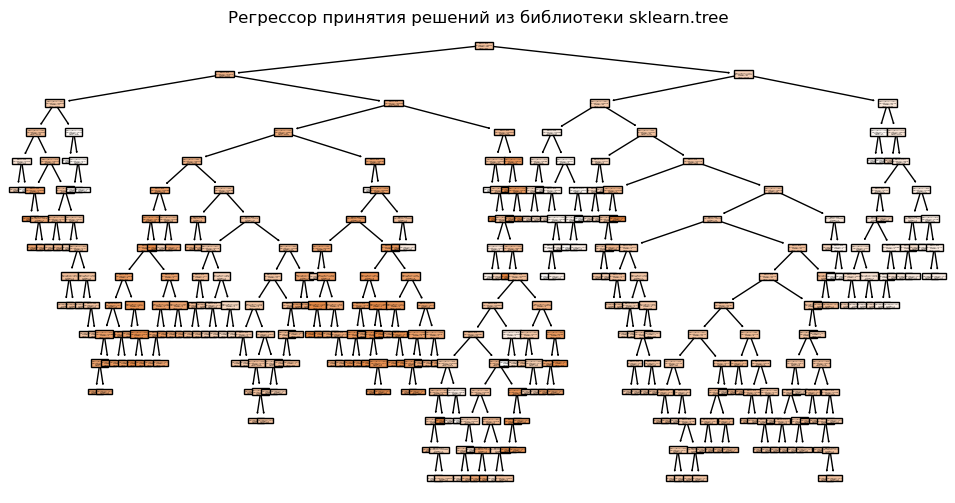

In [34]:
# Построение графа дерева решений DecisionTreeRegressor
plt.figure(figsize=[12, 6], )
plot_tree(sklearn_tree, feature_names=list(features.columns), filled=True)
plt.title('Регрессор принятия решений из библиотеки sklearn.tree')
plt.show()